<a href="https://colab.research.google.com/github/ashikshafi08/Recipe1M/blob/main/01_Recipe_Generator_reading_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading the dataframe 
import pandas as pd 

data = pd.read_csv('/content/drive/MyDrive/Recipe_1M/complete_data.csv')
val_imgs_path = '/content/drive/MyDrive/untitled folder/val/'
data.head(10)

,ID,food_title,partition,image_url,ingredients,instructions,filename
0,00003a70b1,Crunchy Onion Potato Bake,test,http://www.food.com/recipe/crunchy-onion-potat...,2 12 cups milk /t 1 12 cups water /t 14 cup bu...,Preheat oven to 350 degrees Fahrenheit. /t Spr...,3e233001e2.jpg
1,00003a70b1,Crunchy Onion Potato Bake,test,http://www.food.com/recipe/crunchy-onion-potat...,2 12 cups milk /t 1 12 cups water /t 14 cup bu...,Preheat oven to 350 degrees Fahrenheit. /t Spr...,7f749987f9.jpg
2,00003a70b1,Crunchy Onion Potato Bake,test,http://www.food.com/recipe/crunchy-onion-potat...,2 12 cups milk /t 1 12 cups water /t 14 cup bu...,Preheat oven to 350 degrees Fahrenheit. /t Spr...,aaf6b2dcd3.jpg
3,000075604a,Kombu Tea Grilled Chicken Thigh,train,https://cookpad.com/us/recipes/150100-kombu-te...,2 Chicken thighs /t 2 tsp Kombu tea /t 1 White...,Pierce the skin of the chicken with a fork or ...,6bdca6e490.jpg
4,00007bfd16,Strawberry Rhubarb Dump Cake,train,http://www.food.com/recipe/strawberry-rhubarb-...,"6 -8 cups fresh rhubarb, or /t 6 -8 cups froze...",Put ingredients in a buttered 9 x 12 x 2-inch ...,6409eab844.jpg
5,00007bfd16,Strawberry Rhubarb Dump Cake,train,http://www.food.com/recipe/strawberry-rhubarb-...,"6 -8 cups fresh rhubarb, or /t 6 -8 cups froze...",Put ingredients in a buttered 9 x 12 x 2-inch ...,f7cb3de295.jpg
6,000095fc1d,Yogurt Parfaits,train,http://tastykitchen.com/recipes/breakfastbrunc...,"8 ounces, weight Light Fat Free Vanilla Yogurt...",Layer all ingredients in a serving dish.,a1374cdd98.jpg
7,0000b1e2b5,Fennel-Rubbed Pork Tenderloin with Roasted Fen...,train,http://www.epicurious.com/recipes/food/views/f...,1 teaspoon fennel seeds /t 1 pound pork tender...,Preheat oven to 350F with rack in middle. /t C...,cb1a684683.jpg
8,0000c79afb,Pink Sangria,train,http://www.food.com/recipe/pink-sangria-305385,"1 (750 ml) bottle rose wine, chilled /t 14 cup...","In a pitcher, combine all the ingredients exce...",2f4b4c4452.jpg
9,00010379bf,Brown Sugar 'Karintou' Snacks,train,https://cookpad.com/us/recipes/156014-brown-su...,200 grams Cake flour /t 1 tsp Baking powder /t...,"In a bowl, mix flour, baking powder, sugar, th...",f480145da5.jpg


Now we got the data in pandas DataFrame object, lets read the paper more and take notes of it. Also run some codes by creating dummy scenario's.


## Notes from the paper 

So for the modelling experiments we came to know that our recipe generation pipeline is composed of:
- **Image Encoder** -> extract image features (eI) and its parameterized by theta 1 
- **Ingredient Decoder** -> Not sure yet (make preds with theta L)
- **Ingredient Encoder** -> the preds are encoded into a ingredient embeddings eL with [theta e] ) 
- **Instructions Decoder** 
  - this generates a recipe title and a sequence of cooking steps. 
  - this generates is done by attending to image embeddings [eI],  ingredient embeddings [eL] and previously predicted words (r0......rt-1). 
  - parameterized by [thetha r]


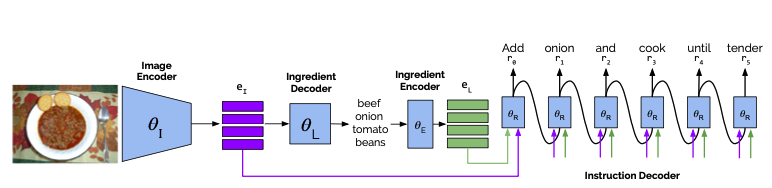

## **3. Generating recipes from images**
In this paper they emphasized about the recipe generation pipeline that starts with predicting the ingredient list at first. After this a sequence of instructions (how to cook the food) will be generated **conditioned on both the image and its corresponding list of ingredients**. 


---


##### **The Model overview**
- Input:  Takes a food image as an input 
- Output: Sequence of cooking instructions 

The outputs are generated by the means of an instruction decoder that takes two embeddings as input, 
- The first one is the features extracted from an image
- The second one encodes ingredients extracted from the image. 

They have used transformer based models especially putting altogether at the end for Instruction Decoder. 


---

First will look into the Instruction transformer, to be more precise the Instruction Decoder that will help us to get sequence of instructions. 

### **3.1 Instruction Transformer**
This takes in a input image with associated ingredients, to produce a sequence of instruction R = (r1 , r2......rT) 
- where rt denotes a word in sequence, 
- rT -> upto the T numbers

The transformer model of this instruction decoder is conditioned jointly on two inputs, 
- image representation `[eI]`  
- ingredient embedding `[eL]`

**How do we get the `eI` and `eL`?**
- The image representation is extracted with a `ResNet50` encoder
- To get the ingredient embedding `[eL]`, they use a decoder architecture to predict the ingredients, followed by a single **embedding layer mapping each ingredient into a fixed vector** `[tf.keras.layers.Embedding()]`. 

#### **Construction of the instruction transformer**

- The instruction decoder is composed of transformer blocks. 
- where each of the transformer blocs contains two attention layers followed by a linear layer. (read the attention is all you need paper). 
- First attention layer:
  - It applies self-attention over previously generated outputs (thats the embedding of both images and ingredients)
- Second attention layer: 
  - attends to the model conditioning in order to refine the self-attention output. 

> The transformer model (the whole thing) is composed of multiple tansformer blocks followed by a linear linear and a softmax non-linearity that provides a distribution over recipe words for each time step t. 


Our recipe generator is conditioned on two sources, 
- the image features `[eI to be an element of set R (P x de)]`
- ingredient embeddings `[eL to be an element of set R (Kxde)]`

where, 
- P -> number of image features 
- K -> number of ingredient features
- de -> embedding dimensionality 

But this traditional transformer model attends only features at a time, but as we know that when we reason both modalities simulataneously, which will help us to derive better instructions for our food. 

##### **Fusion Strategies**
So to achieve this, they use three different fusion strategies: 
- **Concatenated attention**
  - First concatenate both image eI and ingredients eL embeddings over the first dimension. 
  - `[e-concat to be an element of set R (K + P]xde`
  - then the attention is applied over the combined embeddings of both image and instruction.


- **Independent attention**
  - incorporates two attention layers to deal with the bi-model conditioning. 
  - one layer attends the image embedding `eI`
  - another another attends over the ingredient embedding `eL`
  - output of both attention layer is combined via summation operation. 

- **Sequential attention**
  - this more acts like a conditional one, it goes over two conditioning modalities
      - image first, where the attention is first computed over image embeddings [eI] and the over the ingredient embeddings [eL].
      - ingredeients first, where the attention is first computed over ingredient embeddings [eL] and then over the image embeddings [eI].






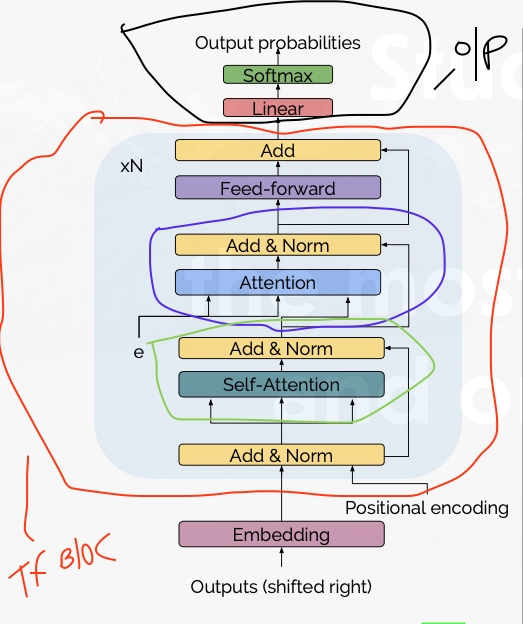

Above is the traditional transformer model lets break it down, 
- At first `Embedding` is the ingredients and image embeddings. 
- Then comes the transformer block which has two self attention layers in it. 
  - its the one with self-attention, and it applies to the output embeddings (image and ingredient embeddings). 
  - second is purely based on us, there are 3 different fusions. 
- Also they have used 2 transformer block, so we gotta create a class of the block and use it multiple times depending upon our needs. 
- then there comes the output layers, where we have a linear layer (simply a dense layer) followed by a softmax for the output distribution

### Visualizing the images 

Lets take 10 samples from our validaton data and convert the long strings of ingredients into a list of ingredients list. 

In [3]:
# Visualizing random images 
import random 
import os
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 


# Creating our imagge path with sub directory partition
fullpath_list = []

for i, filename in enumerate(tqdm(data['filename'])):
  s = filename
  path_str =   s[0] + '/' + s[1] + '/' + s[2] + '/' + s[3] + '/' + data['filename'][i]
  fullpath_list.append(path_str)


# Adding the full path list to our column 
data['full_path'] = fullpath_list


val_df = data[data['partition'] == 'val']



# Getting the full path of the images 
img_path = [val_imgs_path + fn for fn in val_df['full_path']]
img_path[:10]

100%|██████████| 887536/887536 [00:07<00:00, 115015.07it/s]


['/content/drive/MyDrive/untitled folder/val/6/6/5/b/665bbeafc7.jpg',
 '/content/drive/MyDrive/untitled folder/val/8/7/a/e/87aea5035b.jpg',
 '/content/drive/MyDrive/untitled folder/val/a/9/7/9/a97924d704.jpg',
 '/content/drive/MyDrive/untitled folder/val/8/e/9/8/8e98aee7e1.jpg',
 '/content/drive/MyDrive/untitled folder/val/7/0/2/7/7027a5c4f9.jpg',
 '/content/drive/MyDrive/untitled folder/val/f/f/f/3/fff3e1751a.jpg',
 '/content/drive/MyDrive/untitled folder/val/1/f/d/9/1fd9fdddd4.jpg',
 '/content/drive/MyDrive/untitled folder/val/0/c/9/0/0c901c0aee.jpg',
 '/content/drive/MyDrive/untitled folder/val/1/5/b/1/15b1881e50.jpg',
 '/content/drive/MyDrive/untitled folder/val/c/c/7/c/cc7ca17a88.jpg']

In [35]:
# Sample ingredients 
sample_ingredients = val_df['ingredients'].tolist()
len(sample_ingredients)

133842

In [5]:
# Putting them into a list of ingredints list 
sample_ingredient_list = [ing.split(' /t ') for ing in sample_ingredients]

In [6]:
val_df.head()

,ID,food_title,partition,image_url,ingredients,instructions,filename,full_path
17,00029f71f7,Apple Carrot Bones (dog treat),val,https://cookpad.com/us/recipes/369091-apple-ca...,2 1/2 cup wheat flour /t 1/2 cup rolled oats /...,Preheat oven to 350F and line baking sheet wit...,665bbeafc7.jpg,6/6/5/b/665bbeafc7.jpg
18,00029f71f7,Apple Carrot Bones (dog treat),val,https://cookpad.com/us/recipes/369091-apple-ca...,2 1/2 cup wheat flour /t 1/2 cup rolled oats /...,Preheat oven to 350F and line baking sheet wit...,87aea5035b.jpg,8/7/a/e/87aea5035b.jpg
33,0004c091a0,Whole Wheat Waffles,val,http://www.food.com/recipe/whole-wheat-waffles...,1 12 cups whole wheat flour /t 3 teaspoons bak...,"1.In a large bowl, mix together flour, salt, b...",a97924d704.jpg,a/9/7/9/a97924d704.jpg
37,000507ca6b,Frosty Strawberry Squares,val,http://allrecipes.com/recipe/frosty-strawberry...,1 cup all-purpose flour /t 1/2 cup chopped wal...,Preheat oven to 350 degrees F (175 degrees C)....,8e98aee7e1.jpg,8/e/9/8/8e98aee7e1.jpg
45,0006354bc3,Irresistible Peanut Butter Cookies,val,http://www.food.com/recipe/irresistible-peanut...,34 cup creamy peanut butter /t 12 cup Crisco s...,"Combine peanut butter, Crisco, brown sugar, mi...",7027a5c4f9.jpg,7/0/2/7/7027a5c4f9.jpg


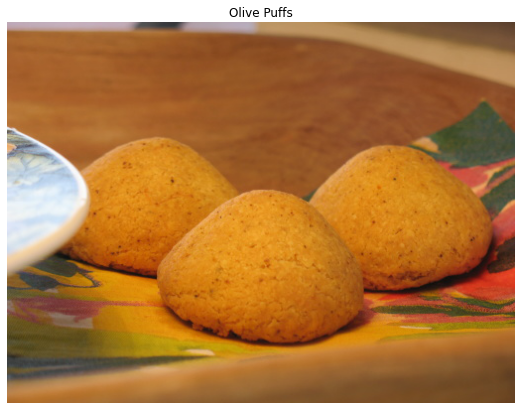

In [7]:

random_index = random.choice(range(len(img_path)))
food_title_list = val_df['food_title'].to_list()

# Visualizing the food 
im = mpimg.imread(img_path[random_index])
plt.figure(figsize = (10 , 7))
plt.imshow(im)
plt.title(food_title_list[random_index])
plt.axis('off');

Finalllyyyy!! From a messed up json file to a delicious mindblowing dishes! We've come so far. 

I can run the above evell all day, and its making me freaking hungry! Alright enough of running the above cell and making myself hungry, lets jump into more paper reading..



## 3.2 Ingredient Decoder 

So far we have been looking at the instruction decoded which helps in getting the output lined up, so we will look into the ingredient decoder that will help us to encode the ingredients. 

But also in this paper they have represented the ingredients in two formats, one is by sets and another one by a list. We will look into them one by one, 
- **Set** : ingredients are a set, since changing the orders of it doesnt alter the outcome for the cooking instruction. 
- **List** : we can even have the ingredients in a list, implying some order. 

Will look into the model addressing both the list and set scenario's. 


---


#### **Ingredients in a list**
List of ingredients is a variable sized, ordered collection of unique meal constituents. 

Lets define a dictionary of ingredients of size `N`, 

`D = {di}N where i = 0` 

where, 
- `N` -> size of the dictionary 
- `di` -> dictionary of ingredients 

From which we can obtain a list of ingredients `L` by selecting `K` elements from the dictionary `D`

`D: L = [li]K i =0` 

where, 
- `K` -> elements 
- `li` -> list of ingredients 

We encode the list `L` as a binary matrix of dimensions `K x N`  dimensions (one hot representations) 

The training data consists of M image and ingredients list pairs 



`argmax of sum of log(s_pred = s_true for sample x)`


In [8]:
# Taking 10 food title and ingredients for experimentations 
sample_food_title = val_df['food_title'].tolist()

x_sample_food = sample_food_title[:10]
l_ingredients_sample = sample_ingredient_list[:10]

x_sample_food

['Apple Carrot Bones (dog treat)',
 'Apple Carrot Bones (dog treat)',
 'Whole Wheat Waffles',
 'Frosty Strawberry Squares',
 'Irresistible Peanut Butter Cookies',
 'Irresistible Peanut Butter Cookies',
 "Joe's Pasta E Fagiolo",
 'Vietnamese chicken wings',
 'Vietnamese chicken wings',
 'Easy Italian-Style Chili']

In [9]:
# Pairing the food title and the ingrediens 
import itertools 

M_sample = itertools.product(x_sample_food , l_ingredients_sample)
M_sample

In [10]:
list(zip(x_sample_food , l_ingredients_sample))

[('Apple Carrot Bones (dog treat)',
  ['2 1/2 cup wheat flour',
   '1/2 cup rolled oats',
   '1 tbsp brown sugar',
   '2 tbsp dried parsley (optional - helps with bad breath)',
   '1 apple - cored, peeled and grated',
   '2 carrots - peeled and grated',
   '1 egg - beaten',
   '1/3 cup vegetable oil',
   '1/4 1/2 cup of water']),
 ('Apple Carrot Bones (dog treat)',
  ['2 1/2 cup wheat flour',
   '1/2 cup rolled oats',
   '1 tbsp brown sugar',
   '2 tbsp dried parsley (optional - helps with bad breath)',
   '1 apple - cored, peeled and grated',
   '2 carrots - peeled and grated',
   '1 egg - beaten',
   '1/3 cup vegetable oil',
   '1/4 1/2 cup of water']),
 ('Whole Wheat Waffles',
  ['1 12 cups whole wheat flour',
   '3 teaspoons baking powder',
   '14 cup extra virgin olive oil',
   '2 eggs',
   '1 cup skim milk',
   '14 teaspoon salt',
   '14 teaspoon cinnamon',
   '14 teaspoon nutmeg',
   '14 teaspoon ground cloves',
   '14 teaspoon ginger',
   '14 teaspoon vanilla',
   '34 cup flax 

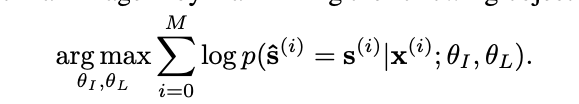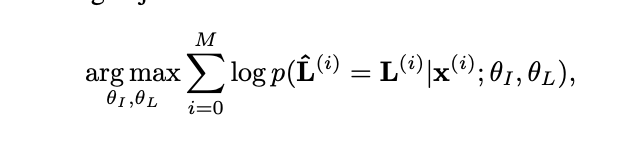

**Why do we use `log p`**? 
When the input value is so small, using the `np.log1p` will help us to get more accurate results than the normal `np.log`.



In [11]:
import numpy as np 

x_sample_food_array = np.array(x_sample_food , dtype = np.float32)
l_ingredients_sample_array =  np.array(l_ingredients_sample , dtype = np.float32)

x_sample_food[:1] , l_ingredients_sample_array[:2]

ValueError: ignored

In [12]:
# Image encoder representation 
img_encoder_rep = [np.random.normal(size = (224 , 224 , 3)) for _ in range(10)]
img_encoder_rep = np.array(img_encoder_rep)

img_encoder_rep.shape

(10, 224, 224, 3)

How to frame the above equation, 
- Take argmax of the whole equation
- Summation 
- Take the log of predictions 

In [29]:
# Converthing the sample ingredients into Embeddings 
import tensorflow as tf 
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding


txt_vect = TextVectorization(max_tokens= 60000 , 
                             output_mode = 'int' , 
                             output_sequence_length = 20)

# Adapt on the ingredient sentences 
txt_vect.adapt()

emb = Embedding(input_dim = 60000 , 
                output_dim = 512 , 
                embeddings_initializer = 'uniform', 
                input_length = 20 , 
                name = 'sample_embedding')


In [33]:
emb(txt_vect(sample_ingredients[23]))

<tf.Tensor: shape=(20, 512), dtype=float32, numpy=
array([[-0.04025156, -0.02581539,  0.02271601, ...,  0.01477046,
        -0.03757633, -0.04669129],
       [-0.03389154, -0.02059523,  0.0459413 , ...,  0.01910715,
        -0.04753226,  0.03859628],
       [-0.00280673,  0.00076134,  0.01772812, ..., -0.02886232,
         0.01449982,  0.00893414],
       ...,
       [ 0.01893631,  0.02034852, -0.00307622, ..., -0.01965387,
        -0.04545143, -0.00616742],
       [ 0.03900174, -0.01587193, -0.04738691, ...,  0.01423533,
        -0.01027383, -0.00668236],
       [ 0.04123554,  0.01890597, -0.00790082, ...,  0.04520389,
         0.00593902, -0.02723614]], dtype=float32)>

### Supplementary Notes 

- Transformer list-based models -> `Tf[list]`
- Set transformer -> `TF [set]`
- Ingredient prediction loss -> `L [ingr]`
- end-of-sequence loss -> `L [eos]`
- cardinality penalty -> `L [card]`
- Trained with BCE loss 




### Tryna build the model (God Bless me)


- Image representation -> cut off the softmax classification layer at the end 
- Ingredient Encoder -> BI-LSTM (word2vec)  
- Instructions Encoder -> Skip instructions vector and its passed into a LSTM. 

Not sure how to build the skip instruction one. 


In [37]:
# Preprocessing function for the images 
def resize_img(image , img_shape = 224):
  image = tf.image.resize(image , size = [img_shape , img_shape])
  return tf.cast(image , tf.float32)

In [ ]:
# Loading in the images 
image_data = tf.keras.utils.image_dataset_from_directory(directory= val_imgs_path  , 
                                                         labels = None , 
                                                         batch_size = None , 
                                                         image_size = (224 , 224) , 
                                                         shuffle = True )

In [ ]:
image_data

In [ ]:
# Image representation 
from tensorflow.keras.applications import resnet50 


classes = len(val_df['food_title'].value_counts())

